In [1]:
import scipy.ndimage
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from scipy.ndimage import gaussian_filter
from matplotlib import rcParams
from helper import helicity 

warnings.filterwarnings("ignore")
# rcParams['font.family'] = 'Courier New'

def labels(ax, flag = False):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    if flag == False:
        ax.text(1 * np.pi / 4, 30, 'Downshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(3 * np.pi / 4, 30, 'Upshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(5 * np.pi / 4, 30, 'Upshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(7 * np.pi / 4, 30, 'Downshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
    
        ax.annotate('', xy=(0, 10), xytext=(np.pi, 10),
                arrowprops=dict(facecolor='black', edgecolor='black', width=1, headwidth=8, headlength=10, path_effects=[pe.withStroke(linewidth=2.25, foreground="white")]))

    ax.set_yticklabels(['10km', '20km', '30km', '40km', '50km', '', '60km', '', ''], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])
    ax.set_ylim(0, 50)

def rePoPolar(dataset, offset = 0):
    x = dataset.density_x.values
    y = dataset.density_y.values
    x, y = np.meshgrid(x, y)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(np.nanmin(r), np.nanmax(r), 200)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    for i in range(len(tBins)):
            tBins[i] = tBins[i] + offset
            while tBins[i] <= (-1 * np.pi):
                tBins[i] = tBins[i] + (2 * np.pi)
            while tBins[i] >= np.pi:
                tBins[i] = tBins[i] - (2 * np.pi)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return polar

def add_storm_dim(dataset):
    dataset = dataset.assign_coords(case=("case", dataset["case_number_global"].values))
    
    return dataset

def getAngles(dataset, caseList):
    l = []
    for x in range(len(caseList)):
        value = caseList[x]
        temp = dataset.isel(num_cases = value)
        l.append(temp.values)
    return np.array(l)

def getData(dataset, case):
    shd = case

    print('Shear direction', shd)
    temp = dataset

    offset = (np.pi / 2) + np.deg2rad(shd)
    temp = rePoPolar(temp, offset)
    # rad = 4
    temp = temp['data']#.sel(r = slice(0, rad))
    temp.values = np.flip(temp.values, axis = 1)
    # newR = np.linspace(0, rad, 200)
    # temp = temp.interp(r = newR)

    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    # ax.set_theta_zero_location("N")
    # ax.set_theta_direction(-1)
    # plt.pcolormesh(temp.theta, temp.r, temp.values)
    # plt.show()

    return temp

def makeComposites(dataset, list):
    data = []
    for x in range(len(list)):
        dat = getData(dataset.isel(case = x), list[x])
        data.append(dat)

    return data

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def tempAnoms6():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/20, "#f2b3d2"),
    (3/20, "#401329"),
    (5/20, "#802525"),
    (7.5/20, "#ff4d4d"),
    (10/20, "#FFFFFF"),
    (12.5/20, "#4d4dff"),
    (15/20, "#252580"),
    (17/20, "#291340"),
    (20/20, "#d3b3f2")])

    vmin = -5
    vmax = 5

    return newcmp.reversed()

In [3]:
def filterByParam(data, var, value, operator):
    filtered = []
    for x in range(len(data)):
        if operator == '>' and (var[x] > value):
            filtered.append(data[x])
        elif operator == '>=' and (var[x] >= value):
            filtered.append(data[x])
        elif operator == '<' and (var[x] < value):
            filtered.append(data[x])
        elif operator == '<=' and (var[x] <= value):
            filtered.append(data[x])

    return filtered

In [4]:
data = xr.open_mfdataset([r"C:\Users\deela\Downloads\split" + str(x) +"_analysis.nc" for x in range(1, 5)], preprocess = add_storm_dim)
print(list(data.variables))

tcradar = xr.open_mfdataset([r"C:\Users\deela\Downloads\tc_radar_v3m_1997_2019_xy_rel_swath_ships.nc", r"C:\Users\deela\Downloads\tc_radar_v3m_2020_2024_xy_rel_swath_ships.nc"], concat_dim='num_cases', combine='nested')
sddc = tcradar["sddc_ships"].sel(ships_lag_times = 0)
shgc = tcradar['shgc_ships'].sel(ships_lag_times = 0)
vent = (tcradar['shdc_ships'].sel(ships_lag_times = 0) * (100 - tcradar['rhmd_ships'].sel(ships_lag_times = 0))) / tcradar['mpi_ships'].sel(ships_lag_times = 0)
vmax = tcradar['vmax_ships'].sel(ships_lag_times = 0)
mpi = tcradar['mpi_ships'].sel(ships_lag_times = 0)

['obsx', 'obsy', 'obs_tilt_mag', 'predx_mean', 'predy_mean', 'predx_median', 'predy_median', 'climoXsv', 'climoYsv', 'tree_preds_x', 'tree_preds_y', 'density_model', 'density_climosv', 'density', 'vmax_init', 'vmax_init_ships', 'dvmax_06h', 'dvmax_12h', 'dvmax_18h', 'dvmax_24h', 'shdc_init', 'rhmd_init', 'mpi_init', 'tc_center_x_2km', 'tc_center_y_2km', 'tc_center_x_6km', 'tc_center_y_6km', 'split', 'index_f', 'index_global', 'index_filtered', 'case_number', 'case_number_global', 'case_number_local', 'variable_index', 'time', 'storm_name', 'mission_id', 'density_y', 'density_x', 'tree', 'case']


In [5]:
angles = 360 - getAngles(sddc, data.case_number_global.values)
shgc = getAngles(shgc, data.case_number_global.values)
vent = getAngles(vent, data.case_number_global.values)
vmax = getAngles(vmax, data.case_number_global.values)
mpi = getAngles(mpi, data.case_number_global.values)

In [6]:
tilt = data['density_model']
clim = data['density_climosv']

tilt = makeComposites(tilt, angles)
clim = makeComposites(clim, angles)

Shear direction 196.0
Shear direction 191.0
Shear direction 191.0
Shear direction 191.0
Shear direction 354.0
Shear direction 3.0
Shear direction 3.0
Shear direction 3.0
Shear direction 5.0
Shear direction 5.0
Shear direction 279.0
Shear direction 279.0
Shear direction 282.0
Shear direction 279.0
Shear direction 279.0
Shear direction 217.0
Shear direction 15.0
Shear direction 300.0
Shear direction 144.0
Shear direction 144.0
Shear direction 282.0
Shear direction 282.0
Shear direction 282.0
Shear direction 12.0
Shear direction 12.0
Shear direction 12.0
Shear direction 111.0
Shear direction 111.0
Shear direction 217.0
Shear direction 332.0
Shear direction 332.0
Shear direction 295.0
Shear direction 295.0
Shear direction 295.0
Shear direction 295.0
Shear direction 295.0
Shear direction 324.0
Shear direction 324.0
Shear direction 260.0
Shear direction 260.0
Shear direction 260.0
Shear direction 260.0
Shear direction 249.0
Shear direction 278.0
Shear direction 278.0
Shear direction 267.0
Sh

In [7]:
test = xr.concat(tilt, dim='case')

In [8]:
test = test.interp(theta = np.linspace(-1 * np.pi, np.pi, 200))
tCoords = test.theta

In [9]:
print(np.nanmin(vmax), np.nanmax(vmax))

30.0 75.0


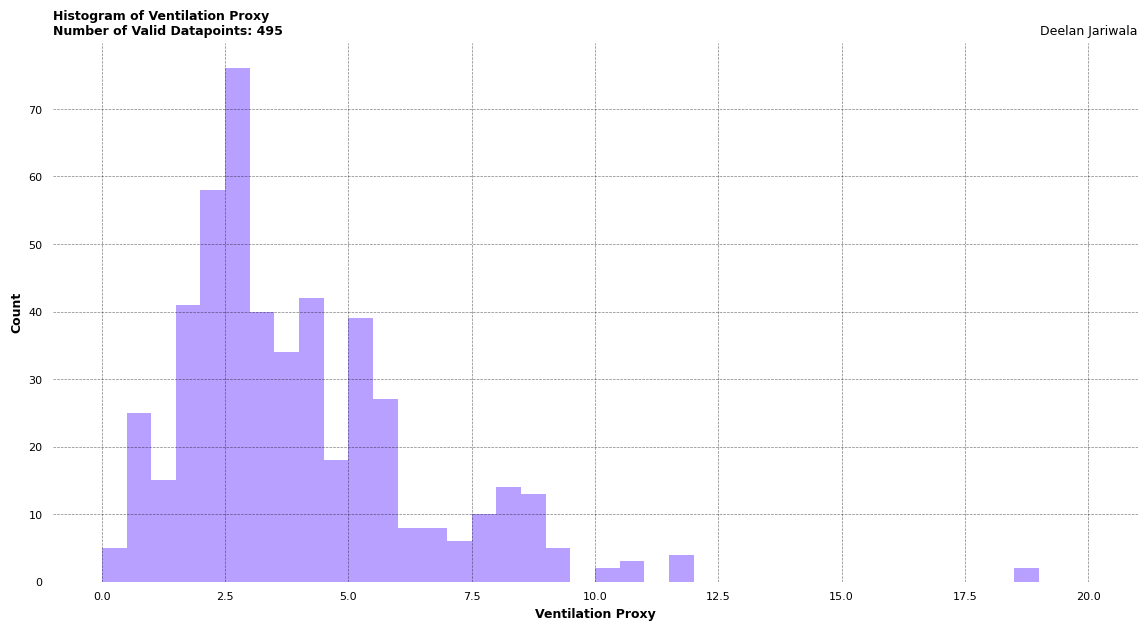

In [10]:
from defaultPlots import histogram

histogram(['Ventilation Proxy', np.array(vent)], bounds = [0, 20.5, .5])

In [11]:
value = 5

sign1 = '<'
finalTilt = filterByParam(tilt, vent, value, sign1)
finalClim = filterByParam(clim, vent, value, sign1)

numCases1 = np.shape(finalTilt)[0]
print(numCases1)
data1 = np.nanmean(finalTilt, axis = 0) - np.nanmean(finalClim, axis = 0)
data1 = gaussian_filter(data1, sigma = 1)

sign2 = '>'
finalTilt = filterByParam(tilt, vent, value, sign2)
finalClim = filterByParam(clim, vent, value, sign2)

numCases2 = np.shape(finalTilt)[0]
print(numCases2)
data2 = np.nanmean(finalTilt, axis = 0) - np.nanmean(finalClim, axis = 0)
data2 = gaussian_filter(data2, sigma = 1)

354
141


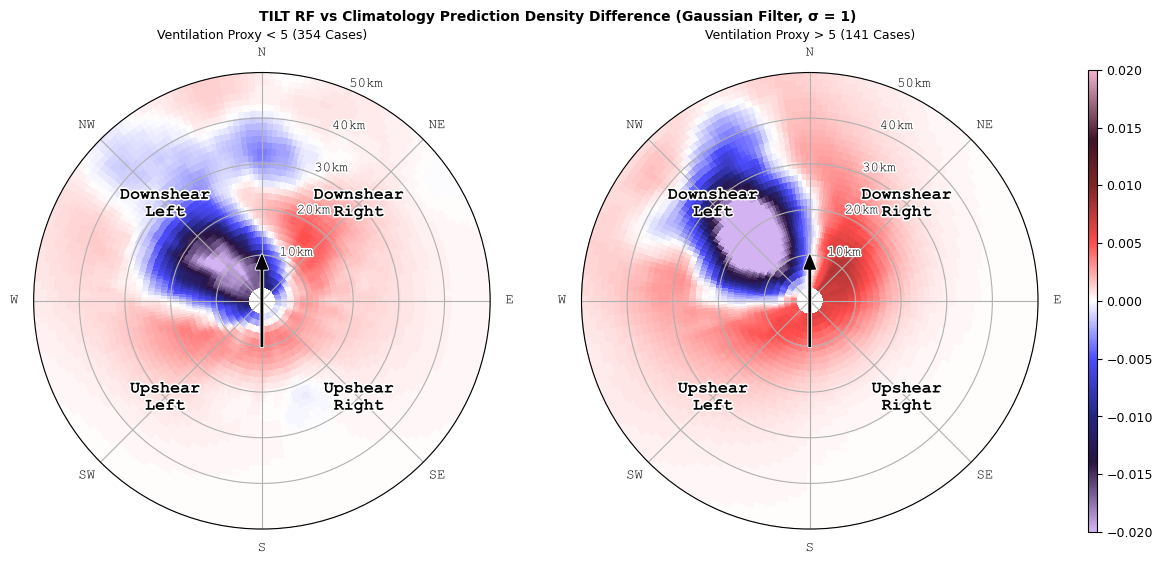

In [12]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (12, 9))
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16, 6))
axes[0].pcolormesh(tCoords, test[0].r, data1, cmap = tempAnoms6(), vmin = -0.02, vmax = 0.02)
labels(axes[0])

c = axes[1].pcolormesh(tCoords, test[0].r, data2, cmap = tempAnoms6(), vmin = -0.02, vmax = 0.02)
labels(axes[1])

# cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .05)
cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

fig.suptitle(f'TILT RF vs Climatology Prediction Density Difference (Gaussian Filter, σ = 1)                               \n\n' , fontweight='bold', fontsize=10)

axes[0].set_title(f'Ventilation Proxy {sign1} {value} ({numCases1} Cases)', fontsize=9)
axes[1].set_title(f'Ventilation Proxy {sign2} {value} ({numCases2} Cases)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\TILTVerificationComposite_vent.png", dpi = 400, bbox_inches = 'tight')
plt.show()